# Chapter 8 Posterior Inference & Prediction

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from plotnine import (
    aes,
    after_stat,
    geom_histogram,
    geom_line,
    ggplot,
    labs,
    stat_function,
)
from scipy import integrate
from scipy.stats import beta, binom, norm, uniform

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%load_ext nb_black
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

In [2]:
def plot_beta_binomial(
    a, b, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = beta.pdf(θ, a, b)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = a + y
    beta_post = b + n - y
    p_theta_given_y_post = beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(
        θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2
    )
    likelihood = binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ,
        likelihood / scale_factor,
        lw=4,
        color="b",
        label="likelihood scaled",
        alpha=0.2,
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()

<IPython.core.display.Javascript object>

In [3]:
result = pyreadr.read_r("data/moma_sample.rda")

<IPython.core.display.Javascript object>

In [4]:
df = result["moma_sample"]

<IPython.core.display.Javascript object>

In [5]:
df.groupby("genx")["artist"].count()

genx
False    86
True     14
Name: artist, dtype: int64

<IPython.core.display.Javascript object>

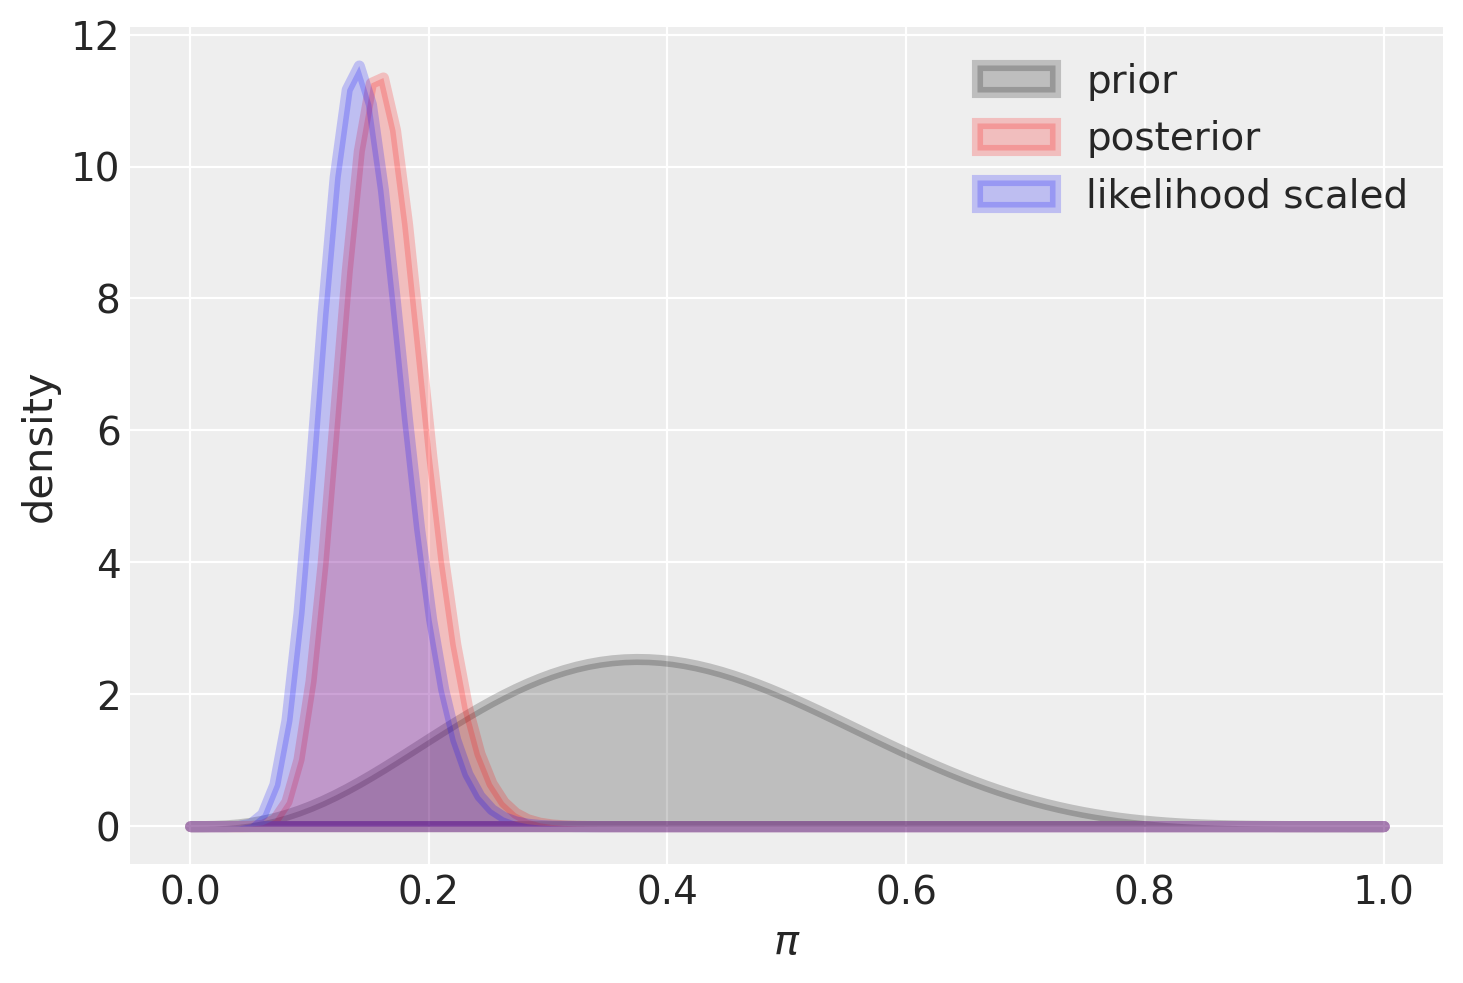

<IPython.core.display.Javascript object>

In [6]:
plot_beta_binomial(a=4, b=6, y=14, n=100)

## 8.1 Posterior estimation

In [7]:
beta.ppf([0.025, 0.975], 18, 92)

array([0.10090844, 0.23792856])

<IPython.core.display.Javascript object>

In [8]:
beta.ppf([0.25, 0.75], 18, 92)

array([0.1388414 , 0.18621971])

<IPython.core.display.Javascript object>

In [9]:
beta.ppf([0.005, 0.995], 18, 92)

array([0.08530422, 0.26468037])

<IPython.core.display.Javascript object>

## 8.2 Posterior hypothesis testing 

### 8.2.1 One-sided tests

In [10]:
post_prob = beta.cdf(0.2, 18, 92)
post_prob

0.848985555953253

<IPython.core.display.Javascript object>

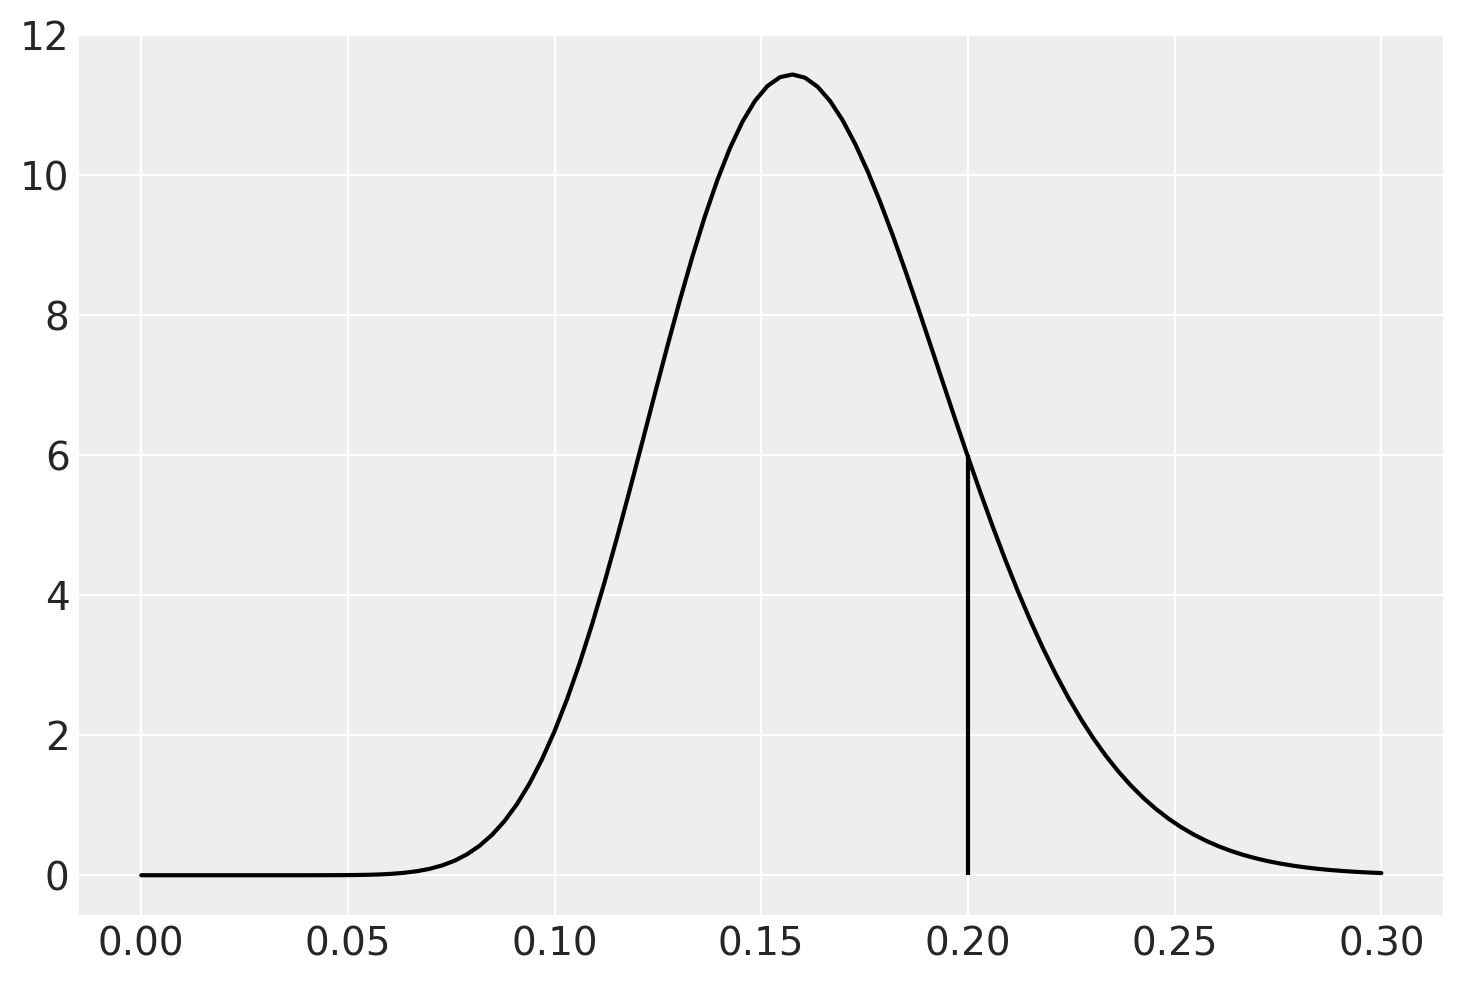

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(1, 1)
a, b = 18, 92
x = np.linspace(0, 0.3, 100)
y = beta.pdf(x, a, b)
ax.plot(x, y, "k")
ax.vlines(0.2, 0, 6, colors="k")
# pt1 = 0
# pt2 = 0.3
# ptx = np.linspace(pt1, pt2, 100)
# ax.fill_between(ptx, y, color="b")

In [13]:
post_odds = post_prob / (1 - post_prob)
post_odds

5.621883133844116

<IPython.core.display.Javascript object>

In [14]:
prior_prob = beta.cdf(0.2, 4, 6)
prior_prob

0.08564172800000006

<IPython.core.display.Javascript object>

(0.0, 12.0)

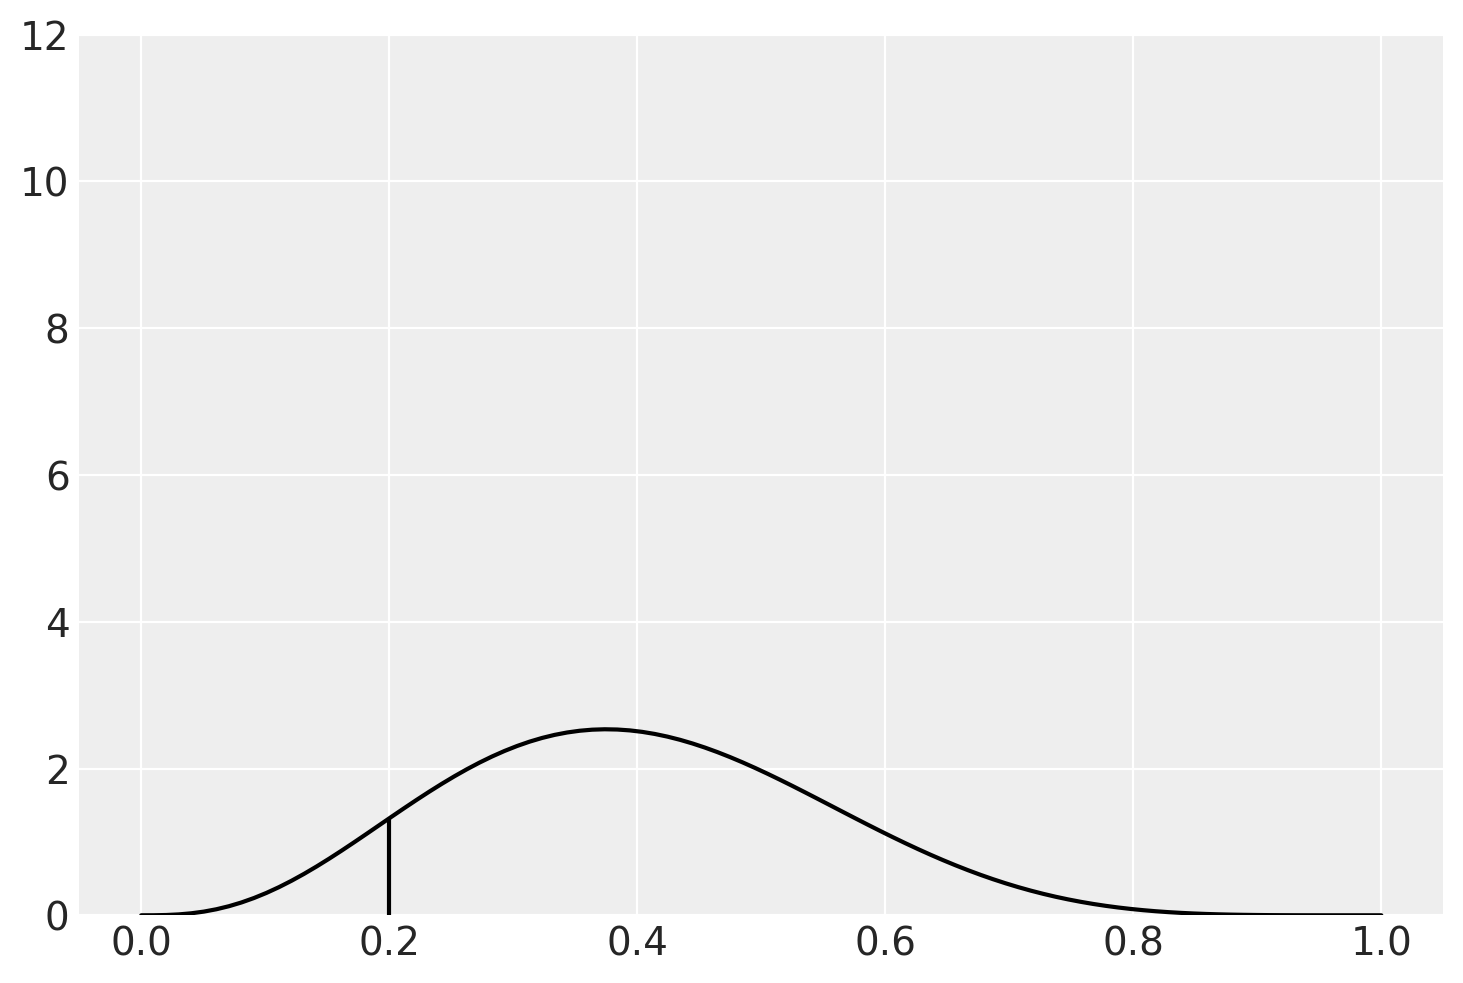

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(1, 1)
a, b = 4, 6
x = np.linspace(0, 1.0, 100)
y = beta.pdf(x, a, b)
ax.plot(x, y, "k")
ax.vlines(0.2, 0, beta.pdf(0.2, a, b), colors="k")
plt.ylim([0, 12])
# pt1 = 0
# pt2 = 0.3
# ptx = np.linspace(pt1, pt2, 100)
# ax.fill_between(ptx, y, color="b")

In [24]:
prior_odds = prior_prob / (1 - prior_prob)
prior_odds

0.09366320688790145

<IPython.core.display.Javascript object>

In [25]:
BF = post_odds / prior_odds
BF

60.022321684677436

<IPython.core.display.Javascript object>

### 8.2.2 Two-sided tests

## 8.3 Posterior prediction

## 8.4 Posterior analysis with MCMC

### 8.4.1 Posterior simulation

In [30]:
num_samples = 5000
n_tune = 5000
n_chains = 4
seed = 84735

with pm.Model() as model:
    p = pm.Beta("p", 4, 6)
    y = pm.Binomial("y", n=100, p=p, observed=14)
    trace = pm.sample(
        num_samples,
        tune=n_tune,
        chains=n_chains,
        return_inferencedata=True,
        random_seed=seed,
    )
    ppc = pm.sample_posterior_predictive(
        trace, random_seed=seed, extend_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc:NUTS: [p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 54 seconds.
INFO:pymc:Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 54 seconds.
/var/folders/1y/pyzwj_b548377277blj2d6xm0000gp/T/ipykernel_74269/1389184368.py:16: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

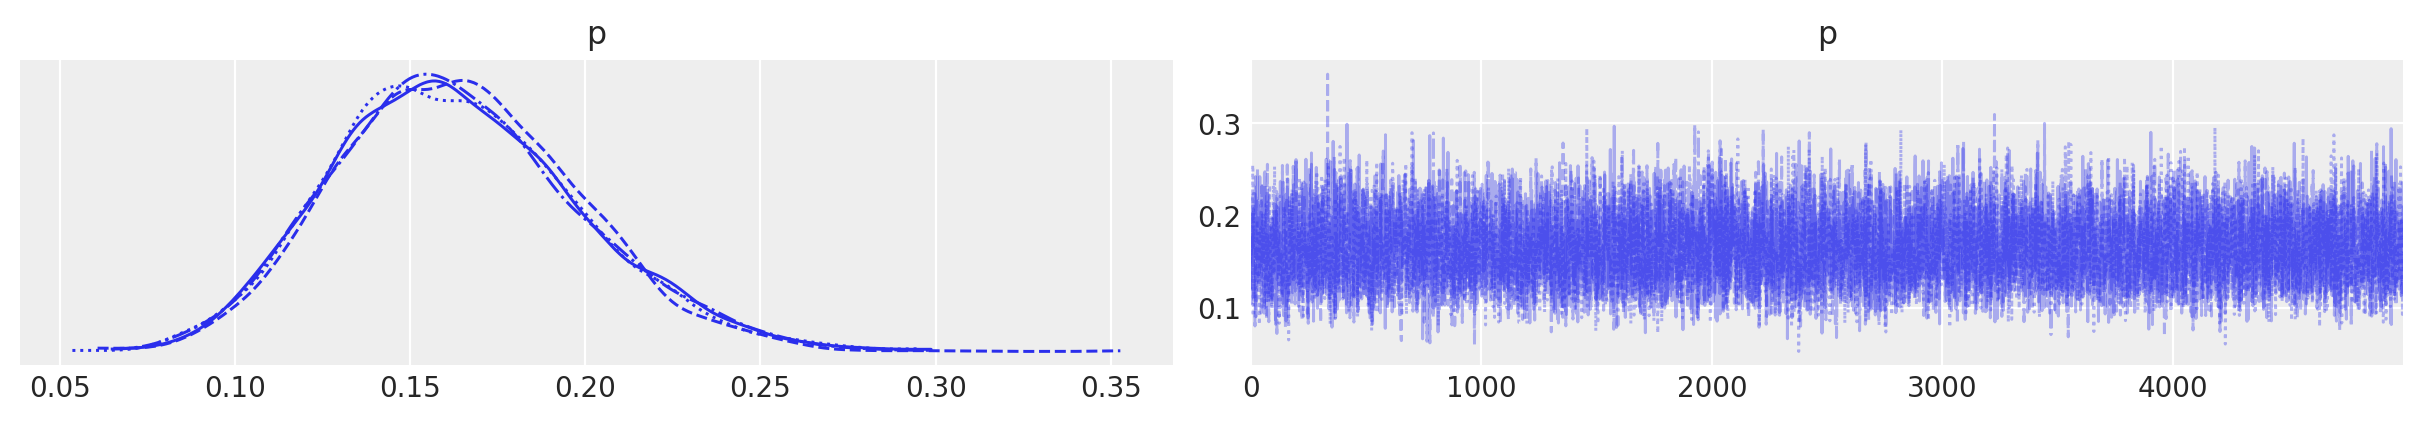

<IPython.core.display.Javascript object>

In [31]:
az.plot_trace(trace)

array([<AxesSubplot:title={'center':'p\n0'}>,
       <AxesSubplot:title={'center':'p\n1'}>,
       <AxesSubplot:title={'center':'p\n2'}>,
       <AxesSubplot:title={'center':'p\n3'}>], dtype=object)

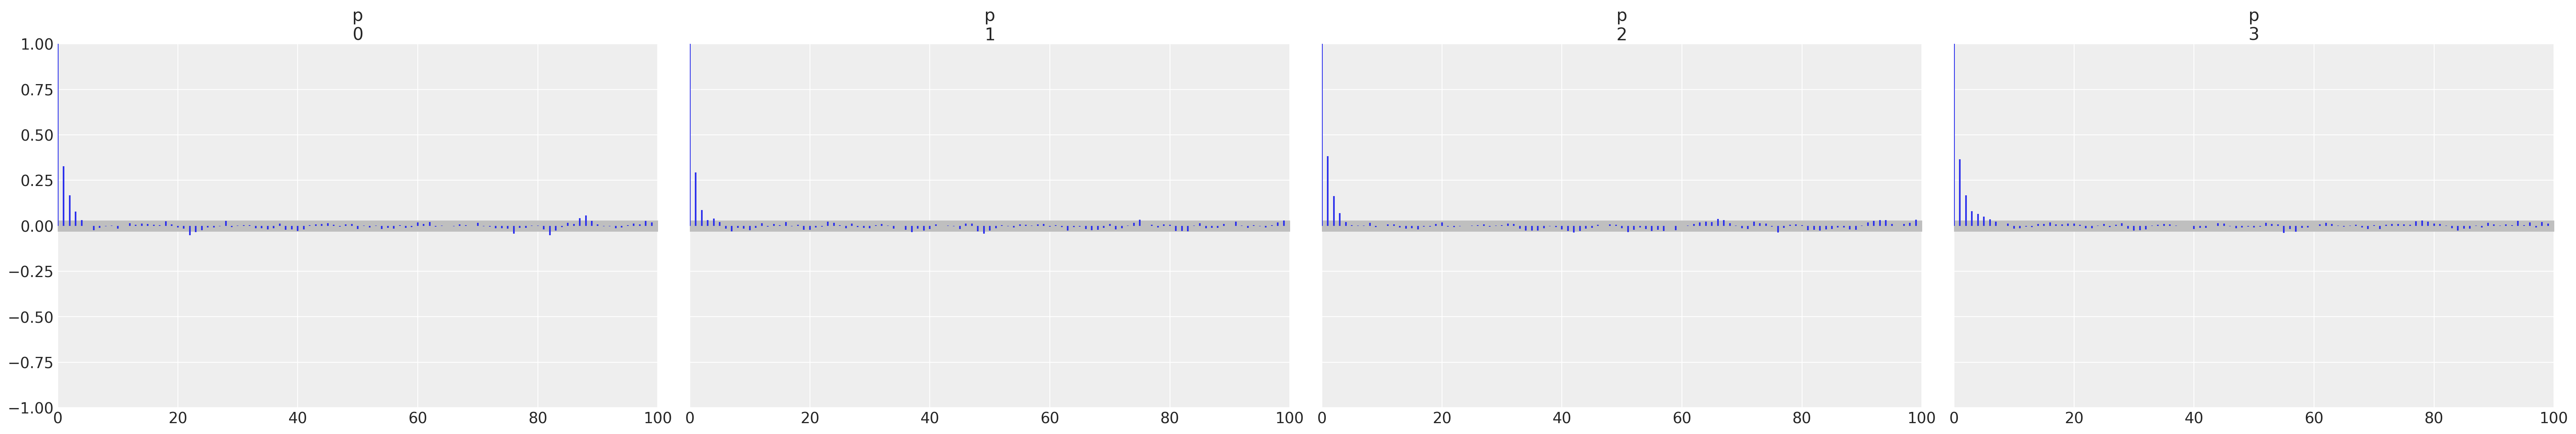

<IPython.core.display.Javascript object>

In [32]:
az.plot_autocorr(trace)

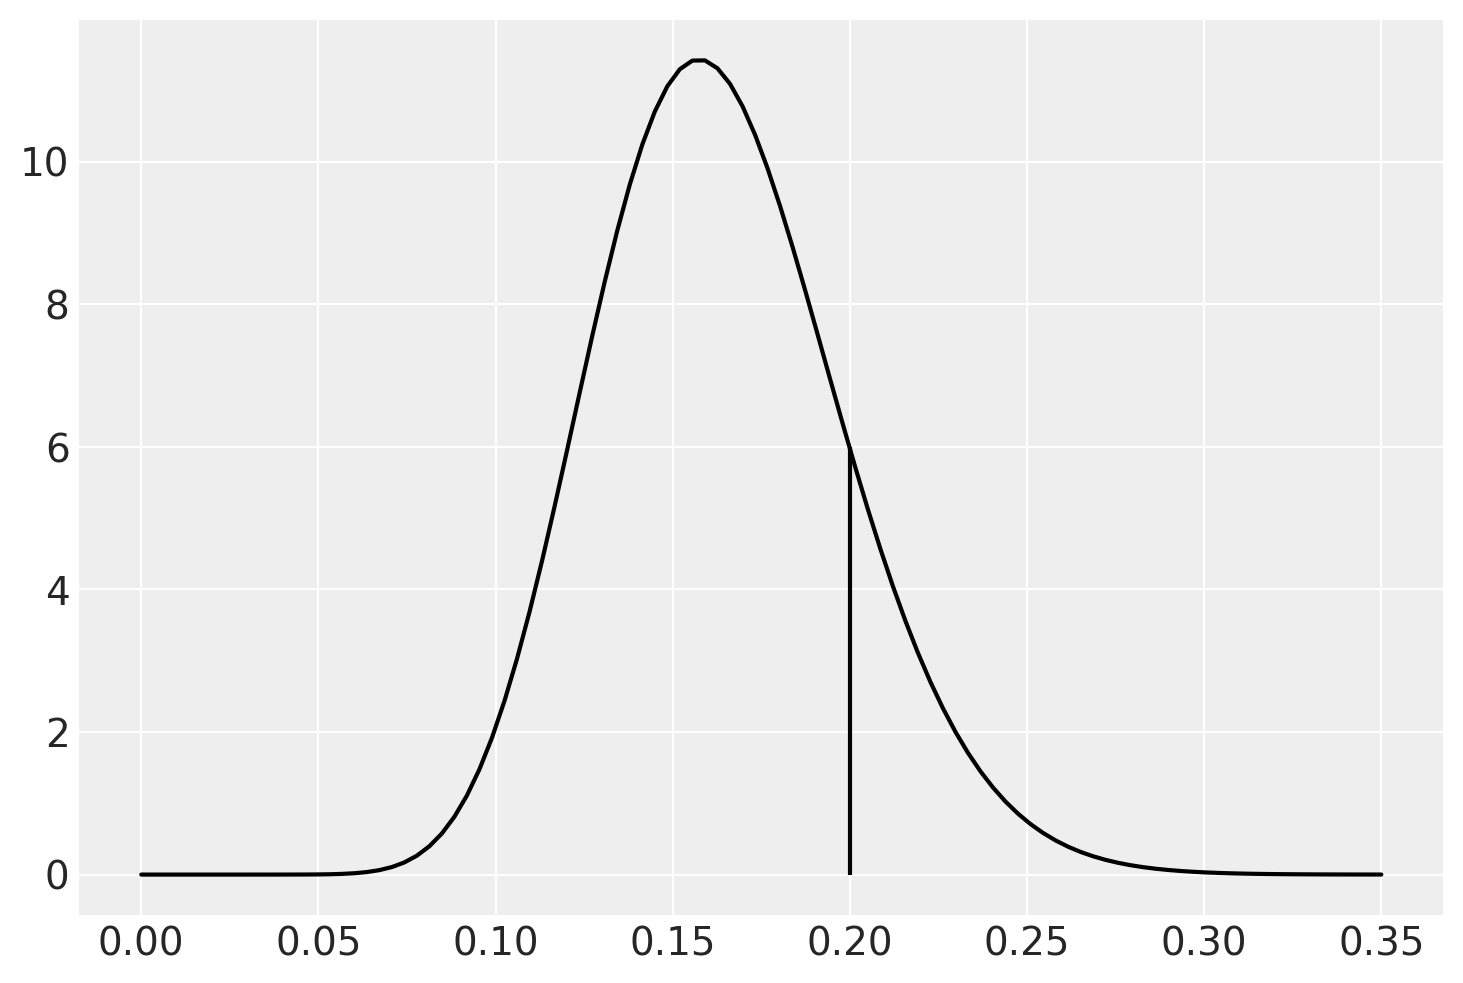

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plt.subplots(1, 1)
a, b = 18, 92
x = np.linspace(0, 0.35, 100)
y = beta.pdf(x, a, b)
ax.plot(x, y, "k")
ax.vlines(0.2, 0, 6, colors="k")

/Users/tomkealy/opt/anaconda3/envs/bayes_rules/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='p', ylabel='Density'>

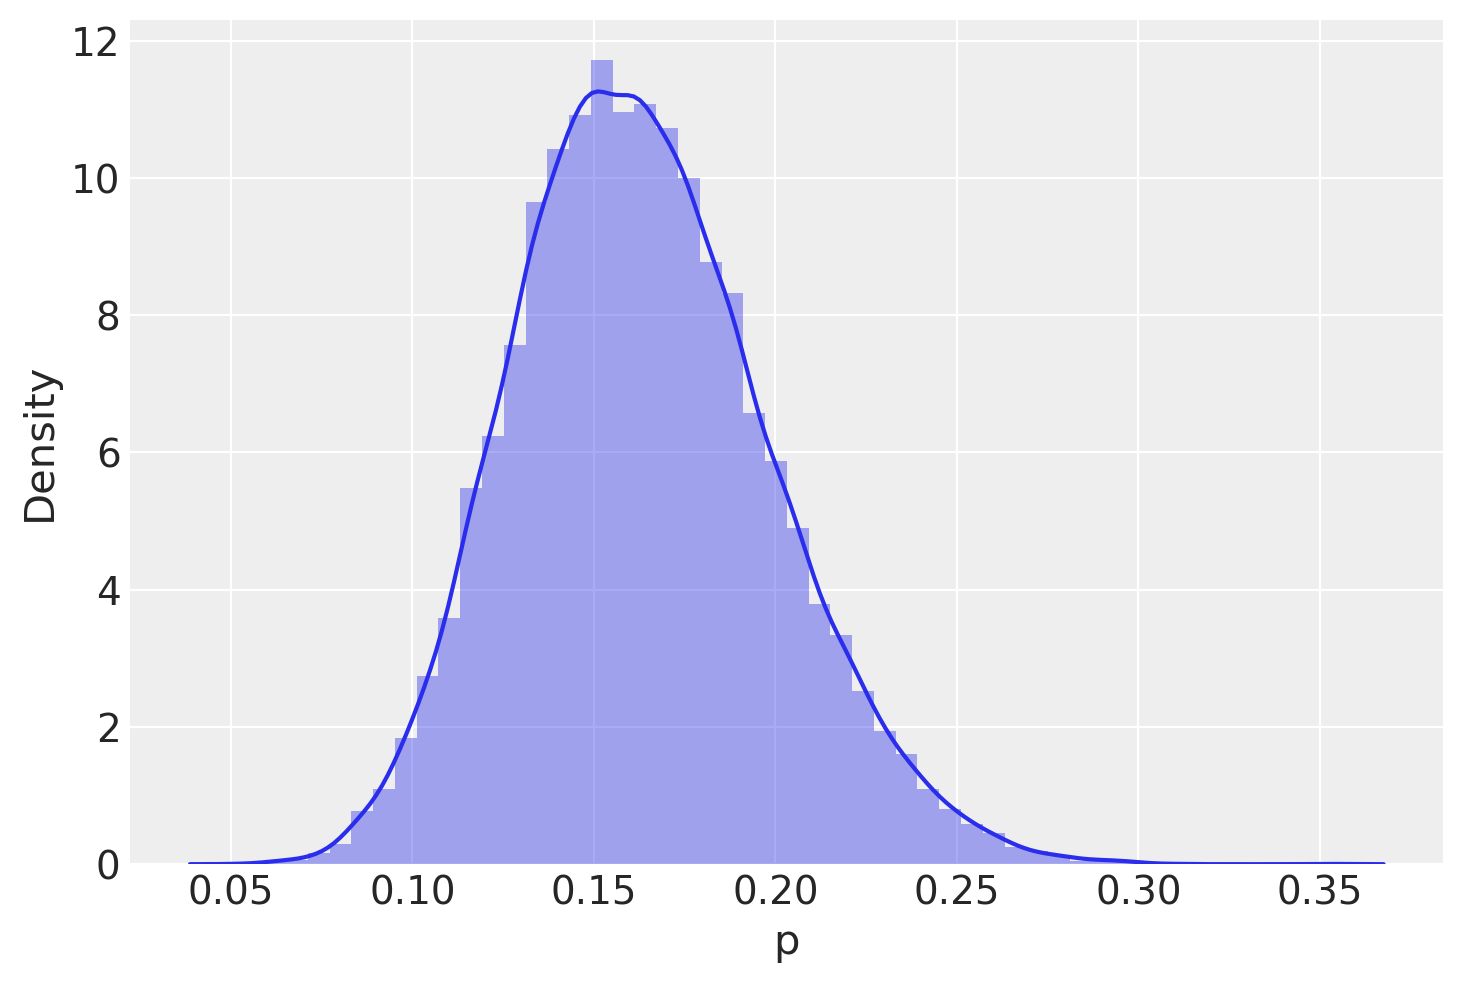

<IPython.core.display.Javascript object>

In [37]:
sns.distplot(trace.posterior.p)

### 8.4.3 Posterior prediction

/Users/tomkealy/opt/anaconda3/envs/bayes_rules/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='y', ylabel='Density'>

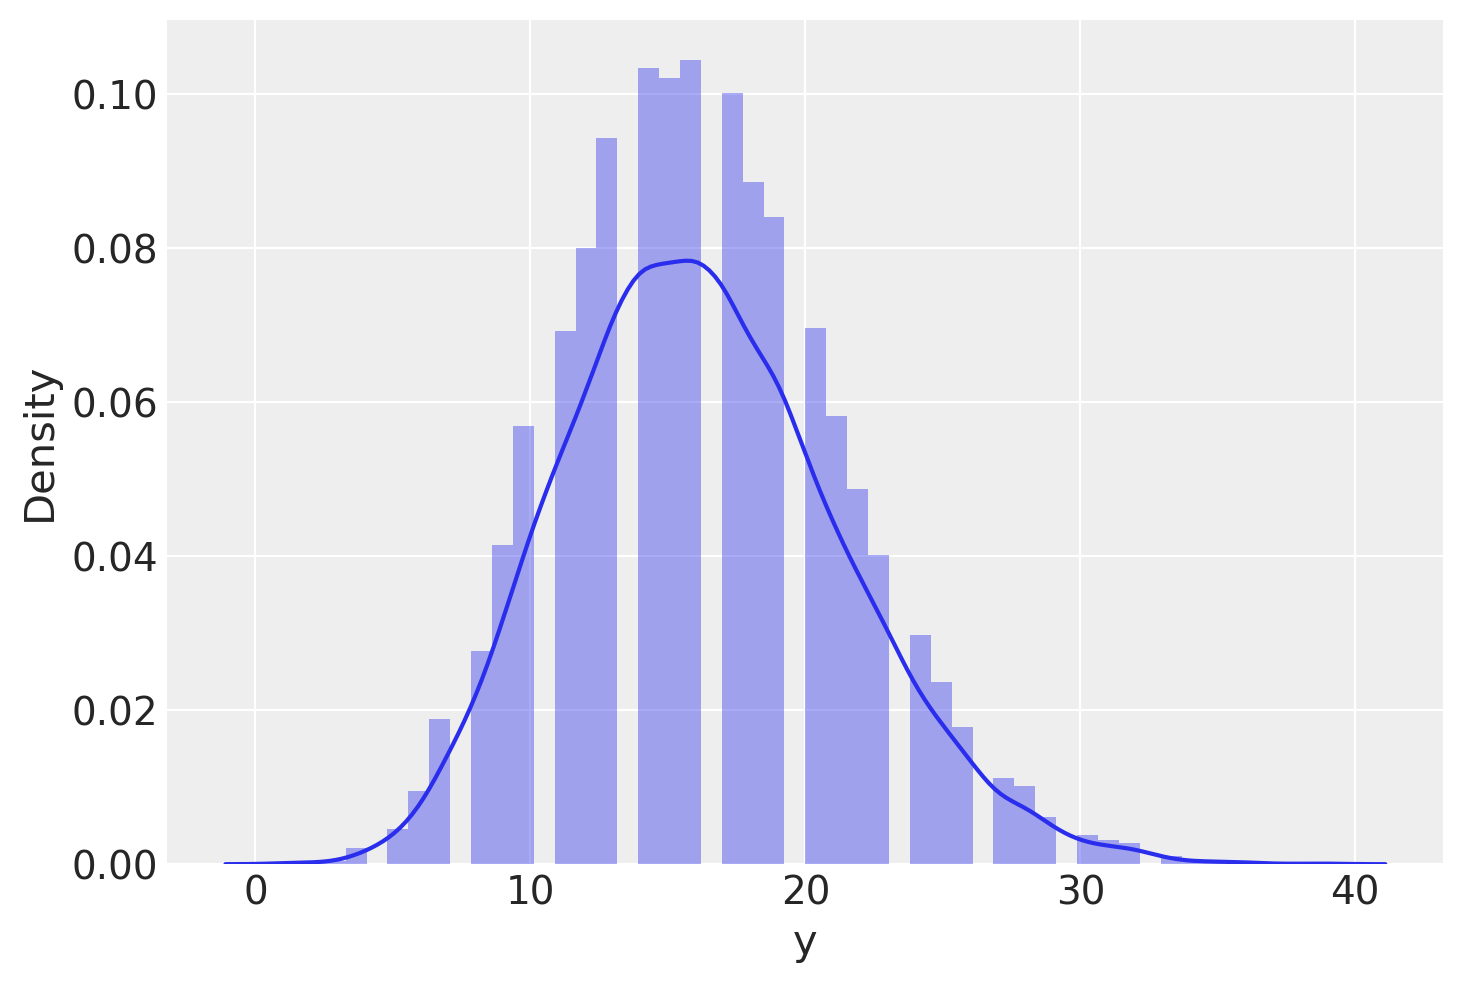

<IPython.core.display.Javascript object>

In [39]:
sns.distplot(ppc.posterior_predictive.y)